In [10]:
import os
from datetime import datetime
from datetime import datetime,date
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans,DBSCAN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

In [11]:
data = pd.read_csv('bank_transactions.csv')
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,"17,819",2/8/16,143207,25
1,T2,C2142763,4/4/57,M,JHAJJAR,"2,271",2/8/16,141858,"27,999"
2,T3,C4417068,26/11/96,F,MUMBAI,"17,874",2/8/16,142712,459
3,T4,C5342380,14/9/73,F,MUMBAI,"866,503",2/8/16,142714,"2,060"
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,"6,714",2/8/16,181156,"1,762"


Этот набор данных состоит из 1 миллиона транзакций более 800 тысяч клиентов для банка в Индии. Данные содержат информацию:
- возраст клиента (DOB)
- местоположение
- пол
- баланс счета во время транзакции 
- дaту транзакции 
- время транзакции
- сумма транзакции (INR - индийская рупия - 0.75 рублей)

In [12]:
#data.drop(["TransactionID"],axis=1,inplace=True) #удаляет id тк они мешаются

In [13]:
data.shape

(1048567, 9)

In [14]:
data.dtypes

TransactionID               object
CustomerID                  object
CustomerDOB                 object
CustGender                  object
CustLocation                object
CustAccountBalance         float64
TransactionDate             object
TransactionTime              int64
TransactionAmount (INR)    float64
dtype: object

In [15]:
pd.options.display.float_format ='{:,.0f}'.format
data.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,"1,046,198","1,048,567","1,048,567"
mean,"115,404","157,088","1,574"
std,"846,485","51,262","6,575"
min,0,0,0
25%,"4,722","124,030",161
50%,"16,792","164,226",459
75%,"57,657","200,010","1,200"
max,"115,035,495","235,959","1,560,035"


In [16]:
data.isna().sum() #проверка на пустые значения

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [17]:
#заменяеи пустые значения на средние
data.CustGender.fillna(data.CustGender.mode().values[0],inplace=True)
data.CustLocation.fillna(data.CustLocation.mode().values[0],inplace=True)
data.CustAccountBalance.fillna(data.CustAccountBalance.median(),inplace=True)

dy = str(int(pd.Series([int(i.split("/")[-3]) for i in data.CustomerDOB.dropna().values]).mode().values[0]))
mn = str(int(pd.Series([int(i.split("/")[-2]) for i in data.CustomerDOB.dropna().values]).mode().values[0]))
yr = str(int(pd.Series([int(i.split("/")[-1]) for i in data.CustomerDOB.dropna().values]).mode().values[0]))
data.CustomerDOB.fillna(dy + "/" + mn + "/" + yr,inplace=True)

In [18]:
data.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [19]:
#дулаем время привычным форматом, округляя минуты
hh = [int(datetime.fromtimestamp(i).strftime("%H")) for i in data.TransactionTime.values]
time = []
for i in hh:
    if i >=0 and i <= 12:
        time.append("AM")
    elif i > 12:
        time.append("PM")
data["TransactionHourOfDay"] = hh
data["TransactionTimeOfDay"] = time

In [20]:
data["TransactionHourOfDay"] = hh
data["TransactionTimeOfDay"] = time
data.drop(["TransactionTime"],inplace=True,axis=1)

In [21]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),TransactionHourOfDay,TransactionTimeOfDay
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,"17,819",2/8/16,25,18,PM
1,T2,C2142763,4/4/57,M,JHAJJAR,"2,271",2/8/16,"27,999",18,PM
2,T3,C4417068,26/11/96,F,MUMBAI,"17,874",2/8/16,459,18,PM
3,T4,C5342380,14/9/73,F,MUMBAI,"866,503",2/8/16,"2,060",18,PM
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,"6,714",2/8/16,"1,762",5,AM


In [22]:
#узнаем возраст клиентов
ages = []
months = [int(i.split("/")[-2]) for i in data.CustomerDOB.values]
years = [int(i.split("/")[-1]) for i in data.CustomerDOB.values]
for i in years:
    if(len(str(i))) == 4:
        ages.append(2022 - i)
    else:
        ages.append(2022 - (1900 + i))
data["CustomerAge"] = ages

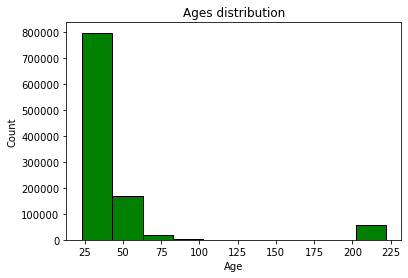

In [23]:
plt.hist(ages,color='green', edgecolor='black')
plt.title("Ages distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [24]:
#уберем вбросы
med = data['CustomerAge'].median()
for i in range(len(ages)):
    if ages[i] > 100:
        ages[i] = med

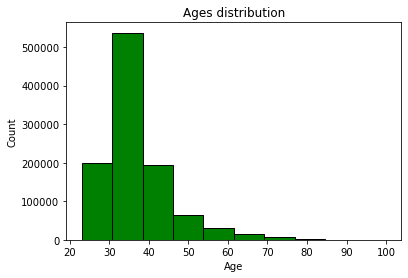

In [25]:
plt.hist(ages,color='green', edgecolor='black')
plt.title("Ages distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [26]:
data["CustomerAge"] = ages

In [27]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),TransactionHourOfDay,TransactionTimeOfDay,CustomerAge
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,"17,819",2/8/16,25,18,PM,28
1,T2,C2142763,4/4/57,M,JHAJJAR,"2,271",2/8/16,"27,999",18,PM,65
2,T3,C4417068,26/11/96,F,MUMBAI,"17,874",2/8/16,459,18,PM,26
3,T4,C5342380,14/9/73,F,MUMBAI,"866,503",2/8/16,"2,060",18,PM,49
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,"6,714",2/8/16,"1,762",5,AM,34


<AxesSubplot:xlabel='TransactionHourOfDay', ylabel='Density'>

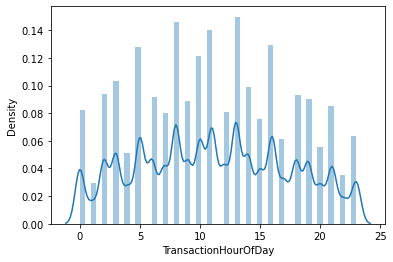

In [28]:
sns.distplot(data['TransactionHourOfDay'])

<AxesSubplot:xlabel='TransactionAmount (INR)', ylabel='Density'>

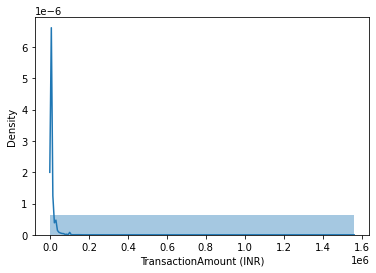

In [29]:
sns.distplot(data['TransactionAmount (INR)'],bins=1, kde=True)

<AxesSubplot:xlabel='CustAccountBalance', ylabel='Density'>

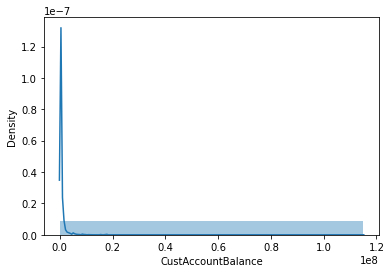

In [30]:
sns.distplot(data['CustAccountBalance'],bins=1, kde=True)

<AxesSubplot:ylabel='TransactionAmount (INR)'>

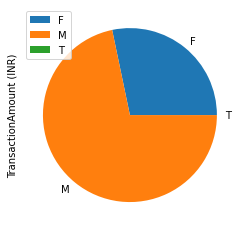

In [31]:
data.groupby(data['CustGender']).sum().plot(kind='pie', y='TransactionAmount (INR)')

In [32]:
data = data.loc[data['CustGender'] != 'T']

<AxesSubplot:ylabel='TransactionAmount (INR)'>

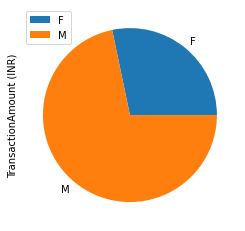

In [33]:
data.groupby(data['CustGender']).sum().plot(kind='pie', y='TransactionAmount (INR)')

In [34]:
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])

data['TransactionMonth'] = data['TransactionDate'].dt.month
data['TransactionDay'] = data['TransactionDate'].dt.dayofweek
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),TransactionHourOfDay,TransactionTimeOfDay,CustomerAge,TransactionMonth,TransactionDay
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,"17,819",2016-02-08,25,18,PM,28,2,0
1,T2,C2142763,4/4/57,M,JHAJJAR,"2,271",2016-02-08,"27,999",18,PM,65,2,0
2,T3,C4417068,26/11/96,F,MUMBAI,"17,874",2016-02-08,459,18,PM,26,2,0
3,T4,C5342380,14/9/73,F,MUMBAI,"866,503",2016-02-08,"2,060",18,PM,49,2,0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,"6,714",2016-02-08,"1,762",5,AM,34,2,0


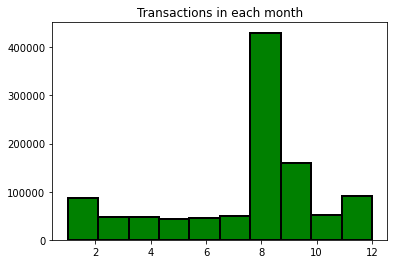

In [35]:
plt.hist(data['TransactionMonth'],color='green', edgecolor='black',bins = 10, linewidth=2)
plt.title('Transactions in each month')
plt.show()

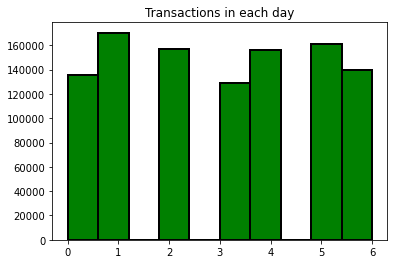

In [36]:
plt.hist(data['TransactionDay'],color='green', edgecolor='black',bins = 10, linewidth=2)
plt.title('Transactions in each day')
plt.show()

In [37]:
#encoded = pd.get_dummies(data.CustLocation)

In [38]:
variables = ['CustAccountBalance', 'TransactionAmount (INR)', 'CustomerAge','TransactionMonth']

<AxesSubplot:>

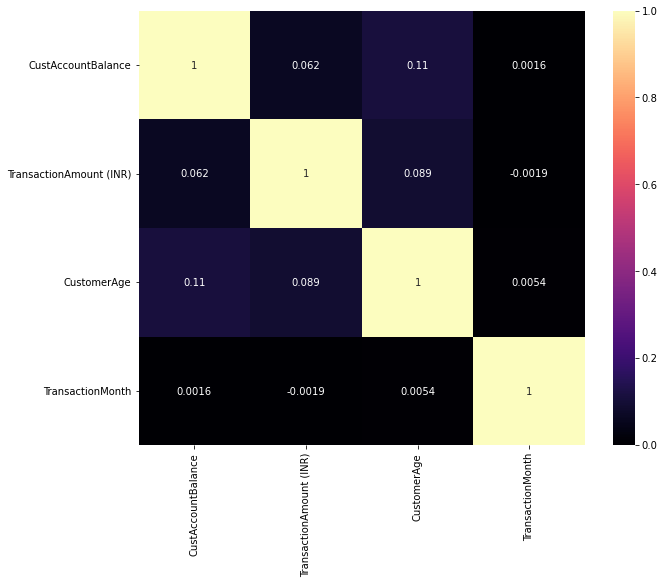

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(data[variables].corr(), annot=True, cmap='magma')

Особой корреляции между числовыми данными нет, проведем кластеризацию

In [40]:
scaler = StandardScaler()
features = scaler.fit_transform(data[variables])

In [41]:
sse = []

for k in range(1, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

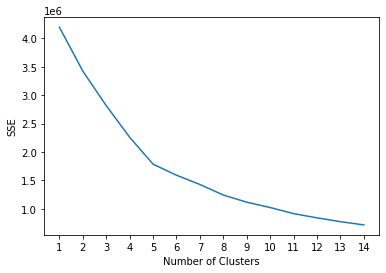

In [42]:
plt.plot(range(1, 15), sse)
plt.xticks(range(1, 15))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

По графику видно, что выборку оптимально можно разбить на 5 кластеров

In [43]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(features)
sse.append(kmeans.inertia_)

In [44]:
data['cluster'] = kmeans.labels_

In [45]:
data.groupby('cluster').agg({v: ['mean', 'median'] for v in variables})

CustAccountBalance            TransactionAmount (INR)         \
                      mean     median                    mean median   
cluster                                                                
0                   71,757     14,621                   1,117    389   
1                  296,993     40,773                   2,152    850   
2               48,200,542 37,254,857                  12,386  2,329   
3                   79,733     14,967                   1,235    447   
4                  487,652    120,000                  73,342 56,509   

        CustomerAge        TransactionMonth         
               mean median             mean median  
cluster                                             
0                34     34                9      8  
1                53     50                8      8  
2                63     67                7      8  
3                35     35                3      3  
4                42     37                7      8

Итого: 

0 и 3 класс отличаются лишь активностью по месяцам - это относительно молодые люди, с небольшим количествов денег на счету
и, соответсвенно, с небольшими транзакциями. 

1 кластер усредненный по возрасту, сумме на счету и сумме транзакции.

4 кластер отличается повышенным балансом на счету, достаточно молодым возрастом как у 0 и 3 кластера и самое главное огромными
суммами транзакции, самыми большими в выборке

2 кластер это богатые люди, с огромными (почти в 100 раз больше чем у 3го) суммами на счету, но не такими большими транзакциями как у 3 кластера. Ещё заметно, что средний возраст в этом кластере 60+

На основе этих данных можно произвести сегментацию.

In [141]:
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),TransactionHourOfDay,TransactionTimeOfDay,CustomerAge,TransactionMonth,TransactionDay,cluster
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,"17,819",2016-02-08,25,18,PM,28,2,0,3
1,T2,C2142763,4/4/57,M,JHAJJAR,"2,271",2016-02-08,"27,999",18,PM,65,2,0,1
2,T3,C4417068,26/11/96,F,MUMBAI,"17,874",2016-02-08,459,18,PM,26,2,0,3
3,T4,C5342380,14/9/73,F,MUMBAI,"866,503",2016-02-08,"2,060",18,PM,49,2,0,3
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,"6,714",2016-02-08,"1,762",5,AM,34,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,"7,635",2016-09-18,799,6,AM,32,9,6,0
1048563,T1048564,C6459278,20/2/92,M,NASHIK,"27,311",2016-09-18,460,6,AM,30,9,6,0
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,"221,757",2016-09-18,770,5,AM,33,9,6,0
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,"10,118",2016-09-18,"1,000",6,AM,44,9,6,1


In [294]:
#data_cluster = data.loc[(data.cluster == 3)  | (data.cluster == 0)]
#data_cluster = data.loc[(data.cluster == 4)]
#data_cluster = data.loc[(data.cluster == 2)]
data_cluster = data

In [295]:
data_cluster

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),TransactionHourOfDay,TransactionTimeOfDay,CustomerAge,TransactionMonth,TransactionDay,cluster,region
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,"17,819",2016-02-08,25,18,PM,28,2,0,3,Other
1,T2,C2142763,4/4/57,M,JHAJJAR,"2,271",2016-02-08,"27,999",18,PM,65,2,0,1,Other
2,T3,C4417068,26/11/96,F,MUMBAI,"17,874",2016-02-08,459,18,PM,26,2,0,3,Big city
3,T4,C5342380,14/9/73,F,MUMBAI,"866,503",2016-02-08,"2,060",18,PM,49,2,0,3,Big city
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,"6,714",2016-02-08,"1,762",5,AM,34,2,0,3,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,"7,635",2016-09-18,799,6,AM,32,9,6,0,Big city
1048563,T1048564,C6459278,20/2/92,M,NASHIK,"27,311",2016-09-18,460,6,AM,30,9,6,0,Other
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,"221,757",2016-09-18,770,5,AM,33,9,6,0,Other
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,"10,118",2016-09-18,"1,000",6,AM,44,9,6,1,Other


In [296]:
data_cluster['start_date'] = data_cluster.groupby('CustomerID')['TransactionDate'].transform('min')

In [297]:

data_cluster['region'] = np.where((data_cluster.CustLocation =='NEW DELHI') 
                                  |(data_cluster.CustLocation =='DELHI')
                                  |(data_cluster.CustLocation =='BANGALORE')
                                  |(data_cluster.CustLocation =='MUMBAI')
                                  ,'Big city', 'Other')

In [298]:
data_cluster['TransactionDate'] = data_cluster['TransactionDate'].apply(pd.to_datetime)

In [299]:
data_cluster

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),TransactionHourOfDay,TransactionTimeOfDay,CustomerAge,TransactionMonth,TransactionDay,cluster,region,start_date
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,"17,819",2016-02-08,25,18,PM,28,2,0,3,Other,2016-02-08
1,T2,C2142763,4/4/57,M,JHAJJAR,"2,271",2016-02-08,"27,999",18,PM,65,2,0,1,Other,2016-02-08
2,T3,C4417068,26/11/96,F,MUMBAI,"17,874",2016-02-08,459,18,PM,26,2,0,3,Big city,2016-02-08
3,T4,C5342380,14/9/73,F,MUMBAI,"866,503",2016-02-08,"2,060",18,PM,49,2,0,3,Big city,2016-02-08
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,"6,714",2016-02-08,"1,762",5,AM,34,2,0,3,Other,2016-02-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,"7,635",2016-09-18,799,6,AM,32,9,6,0,Big city,2016-09-18
1048563,T1048564,C6459278,20/2/92,M,NASHIK,"27,311",2016-09-18,460,6,AM,30,9,6,0,Other,2016-09-18
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,"221,757",2016-09-18,770,5,AM,33,9,6,0,Other,2016-09-15
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,"10,118",2016-09-18,"1,000",6,AM,44,9,6,1,Other,2016-09-18


In [300]:
dd = data_cluster \
        .groupby(['CustomerID', 'TransactionDate', 'start_date', 'region'], as_index=False)['TransactionID'] \
        .nunique()

In [301]:
dd['start_month'] = dd['start_date'].apply(lambda x: x.replace(day=1))

In [302]:
dd['months_diff'] = dd['TransactionDate'] - dd['start_date']
dd['months_diff'] = dd['months_diff'].apply(lambda x: round(x.days/28))

In [303]:
dd = dd[dd.start_month<'2019-01-01']

In [304]:
n_users = dd.groupby(['start_month', 'months_diff', 'region'], as_index=False)['CustomerID'].nunique()

In [305]:
cohorts = n_users \
            .pivot_table(index=['start_month', 'region'], columns='months_diff', values='CustomerID')

In [306]:
cohort_size = cohorts.iloc[:, 0]

In [307]:
retention = cohorts.divide(cohort_size, axis=0)

In [319]:
big_city = retention.loc[:, 'Big city', :].iloc[:, :15]
other = retention.loc[:, 'Other', :].iloc[:, :15]

<AxesSubplot:xlabel='months_diff', ylabel='start_month'>

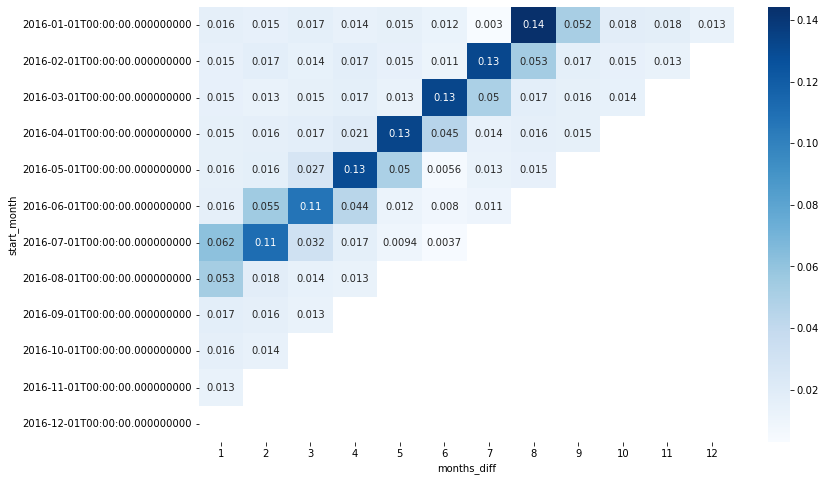

In [320]:
plt.figure(figsize=(12, 8))
             
sns.heatmap(big_city.iloc[:,1:], annot=True, cmap='Blues')

<AxesSubplot:xlabel='months_diff', ylabel='start_month'>

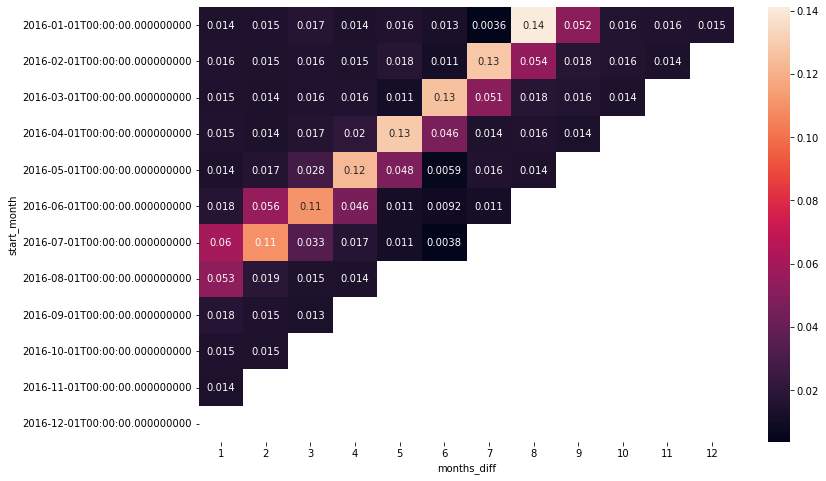

In [310]:
plt.figure(figsize=(12, 8))
sns.heatmap(other.iloc[:,1:], annot=True)

Это retention для 2 кластера, синим - в крупных городах, красным - в остальных. Аналогично можно посмотреть остальные кластеры.

In [311]:
 data["cluster"].value_counts()

0    687334
3    206679
1    150257
4      4123
2       173
Name: cluster, dtype: int64

In [312]:
 data_cluster["region"].value_counts()

Other       707318
Big city    341248
Name: region, dtype: int64

In [313]:

data['region'] = np.where((data.CustLocation =='NEW DELHI') 
                                  |(data.CustLocation =='DELHI')
                                  |(data.CustLocation =='BANGALORE')
                                  |(data.CustLocation =='MUMBAI')
                                  ,'Big city', 'Other')

In [314]:
 data["region"].value_counts()

Other       707318
Big city    341248
Name: region, dtype: int64